(this notebook is adapted by kevin zhu for SYDE 522. The original notebook is from https://github.com/vaasha/Machine-leaning-in-examples/blob/master/sklearn/cross-validation/Cross%20Validation.ipynb)

# Cross-validation
(from Wikipedia)

>In a prediction problem, a model is usually given a dataset of known data on which **training** is run (training dataset), and a dataset of unknown data (or first seen data) against which the model is **tested** (called the validation dataset or testing set). 
>
>The goal of **cross-validation** is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

### K-fold cross-validation
(still from Wikipedia)
>In *k*-fold cross-validation, the original sample is randomly partitioned into *k* equal sized subsamples, often referred to as "folds". Of the *k* subsamples, a single subsample is retained as the validation data for testing the model, and the remaining *k − 1* subsamples are used as training data. The cross-validation process is then repeated *k* times, with each of the *k* subsamples used exactly once as the validation data. The *k* results can then be averaged to produce a single estimation. 
>
>The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once. 

More: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

![](Cross_Validation.jpg "Cross validation folds")

### Implementation
In this notebook, we will explore the `Scikit-learn` library's implementation of cross-validation in python.
Their official documentation is here: https://scikit-learn.org/stable/modules/cross_validation.html.

`Scikit-learn` is a popular open source library that offers tools for predictive data analysis. More:
https://scikit-learn.org/stable/getting_started.html.

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.datasets import load_iris 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from utils import plot_kfold

pd.options.mode.chained_assignment = None
%matplotlib inline

## K-fold cross-validation

Before using sklearn, let's implement k-fold cross-validation from scratch.

In [1]:
""" 
Performs vanilla K-fold split on a dataset of length N.
Returns the indices of the training and test set for each fold.

Args:
    K (int): number of folds.
    N (int): total number of observations in dataset.

Returns:
    A list of K tuples of size 2: 

        [ (train_idx_1, test_idx_1),
          (train_idx_2, test_idx_2), 
          ..., 
          (train_idx_K, test_idx_K) ]

        where:
            train_idx_k (list): indices of training data for the kth fold.
            test_idx_k (list): indices of test data for the kth fold.

        

Example:
    vanilla_kfold(K=3, N=6) should return:

    [([2, 3, 4, 5], [0, 1]), 
     ([0, 1, 4, 5], [2, 3]), 
     ([0, 1, 2, 3], [4, 5])]

Note: all observations should appear once in the test set. Example:
    vanilla_kfold(K=3, N=7) should return:
    
    [([2, 3, 4, 5, 6],  [0, 1]),
     ([0, 1, 4, 5, 6],  [2, 3]),
     ([0, 1, 2, 3],     [4, 5, 6])]
    
    or [([3, 4, 5, 6],     [0, 1, 2]),
        ([0, 1, 2, 5, 6],  [3, 4]),
        ([0, 1, 2, 3, 4],  [5, 6])]

"""


def vanilla_kfold(K, N):
    testsize = N // K
    print(testsize)
    idx = set(range(N))
    print(idx)

    folds = []
    for k in range(K):
        start = k * testsize
        end = (k + 1) * testsize if k < (K - 1) else N

        test_idx = set(range(start, end))
        train_idx = idx - test_idx

        fold = (list(train_idx), list(test_idx))
        folds.append(fold)

    return folds

Let's split some fake data of size 25 into 5 folds using our implementation...

In [6]:
# create some fake data of size 25
N_fake = 25
fakedata = np.arange(N_fake)

# plot the indices
print("for 5-fold:")
for i, (train_index, test_index) in enumerate(vanilla_kfold(5, N_fake)):
    print("Fold {}: Train idx {};   Test idx {}".format(i + 1, train_index, test_index))

for 5-fold:
Fold 1: Train idx [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24];   Test idx [0, 1, 2, 3, 4]
Fold 2: Train idx [0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24];   Test idx [5, 6, 7, 8, 9]
Fold 3: Train idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24];   Test idx [10, 11, 12, 13, 14]
Fold 4: Train idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24];   Test idx [15, 16, 17, 18, 19]
Fold 5: Train idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19];   Test idx [20, 21, 22, 23, 24]


Let's plot results for 5- and 3-folds.

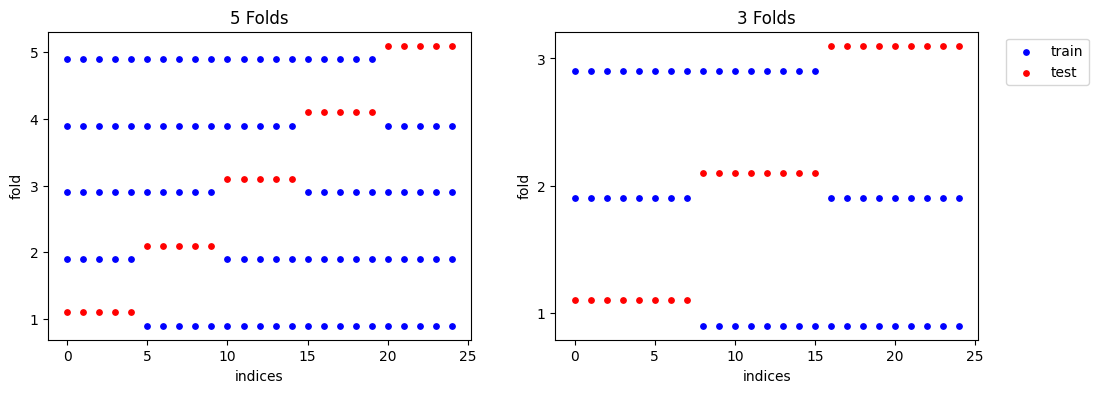

In [7]:
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, vanilla_kfold(5, N_fake), N_fake)
ax.set_title("5 Folds")

ax = plt.subplot(122)
plot_kfold(ax, vanilla_kfold(3, N_fake), N_fake)
plt.yticks(np.arange(1, 4, 1))
ax.set_title("3 Folds")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

Let's compare to sklearn's implementation.

In [8]:
kf5 = KFold(n_splits=5, shuffle=False)  # 5-fold
kf3 = KFold(n_splits=3, shuffle=False)  # 3-fold

# print indices for 5-fold:
print("for 5-fold:")
for i, (train_index, test_index) in enumerate(kf5.split(fakedata)):
    print("Fold {}: Train idx {};   Test idx {}".format(i + 1, train_index, test_index))

for 5-fold:
Fold 1: Train idx [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24];   Test idx [0 1 2 3 4]
Fold 2: Train idx [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24];   Test idx [5 6 7 8 9]
Fold 3: Train idx [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24];   Test idx [10 11 12 13 14]
Fold 4: Train idx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24];   Test idx [15 16 17 18 19]
Fold 5: Train idx [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19];   Test idx [20 21 22 23 24]


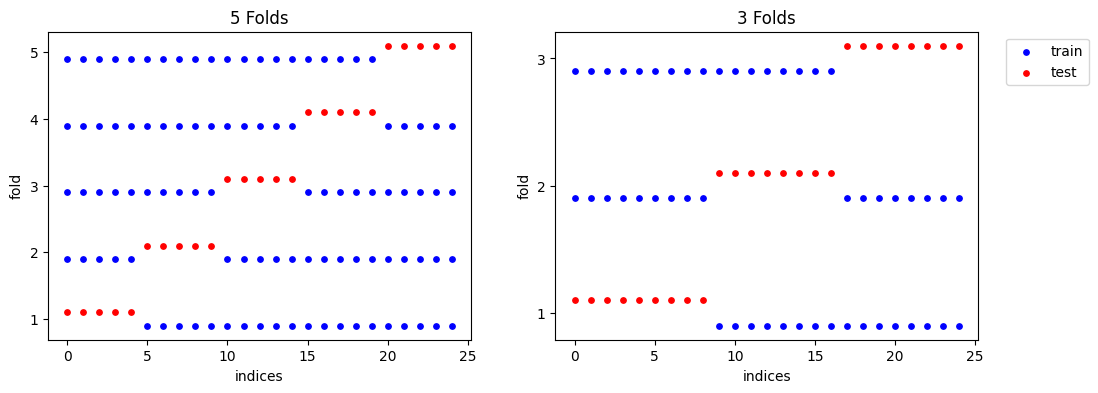

In [9]:
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf5.split(fakedata), N_fake)
ax.set_title("5 Folds")

ax = plt.subplot(122)
plot_kfold(ax, kf3.split(fakedata), N_fake)
plt.yticks(np.arange(1, 4, 1))
ax.set_title("3 Folds")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## Shuffled K-fold
We can also shuffle the test indices for each fold by setting `shuffle = True`. Each observation should still appear in the test set once after all folds.

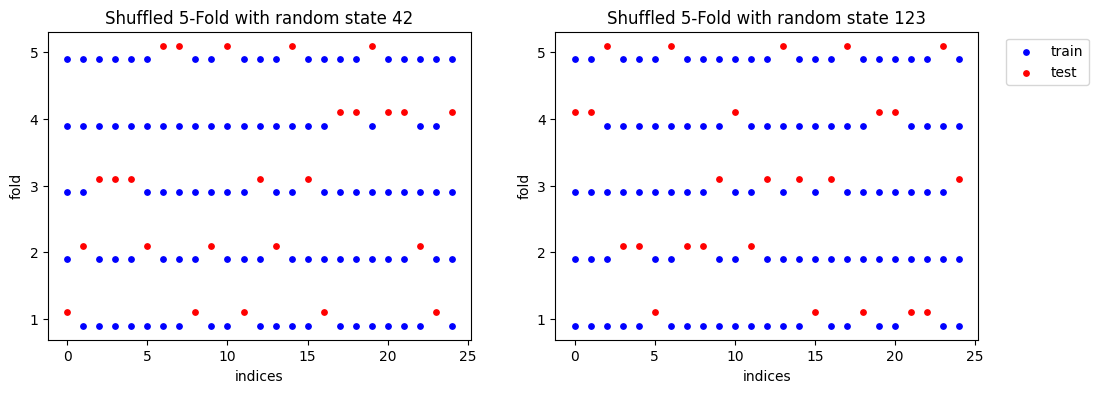

In [11]:
# shuffled 5-fold with different random states
kf5_shuffled42 = KFold(n_splits=5, shuffle=True, random_state=42)
kf5_shuffled123 = KFold(n_splits=5, shuffle=True, random_state=123)

# ====================================================================================
# plot
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf5_shuffled42.split(fakedata), N_fake)
ax.set_title("Shuffled 5-Fold with random state 42")

ax = plt.subplot(122)
plot_kfold(ax, kf5_shuffled123.split(fakedata), N_fake)
ax.set_title("Shuffled 5-Fold with random state 123")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

## K-fold on the Iris dataset

Let's use K-fold to evaluate a classification model on the popular Iris Dataset. 

The Iris dataset contains 150 samples of petal and sepal sizes for 3 species of irises' - setosa, versicolor and virginica. More: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [12]:
iris = load_iris(return_X_y=False)  # load Iris dataset from sklearn

iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

features = iris["feature_names"]
iris_df["target"] = iris.target
iris_df["target_name"] = iris_df["target"].map(
    {i: name for i, name in enumerate(iris.target_names)}
)

print("Data overview:")
iris_df.sample(5)

Data overview:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
78,6.0,2.9,4.5,1.5,1,versicolor
101,5.8,2.7,5.1,1.9,2,virginica
106,4.9,2.5,4.5,1.7,2,virginica
38,4.4,3.0,1.3,0.2,0,setosa
39,5.1,3.4,1.5,0.2,0,setosa


The occurrence of the classes are evenly distributed in the dataset. There are 50 samples of each species (1/3 of entire data).

In [13]:
# Let's check the occurrence of each class
pd.DataFrame(iris_df.groupby("target_name").size().reset_index()).rename(
    columns={0: "sample size"}
)

,target_name,sample size
0,setosa,50
1,versicolor,50
2,virginica,50


### Without K-fold

Let's start without K-fold.

We split the data randomly into training and test sets using `train_test_split`.

We fit a logistics regression model on the training set to classify the Iris species from petal and sepal sizes. We evaluate our model on the test set.

In [ ]:
# split data into 80% train and 20% test set (no kfold)
X = iris_df[features]
y = iris_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# initialize the model (logistic regression)
model = LogisticRegression(solver="liblinear", multi_class="auto")

# fit the model
model.fit(X_train, y_train)  # fit the model

# evaluate results:
pd.DataFrame(
    {
        "Accuracy on Train": [accuracy_score(y_train, model.predict(X_train))],
        "Accuracy on Test": [accuracy_score(y_test, model.predict(X_test))],
    }
)

### K-fold (K=3)

Now, let's evaluate using 3-fold cross-validation.

For each fold, we fit a logistic regression model on the training set and evaluate on the test set.

In [ ]:
for i, (train_index, test_index) in enumerate(
    kf3.split(iris_df)
):  # train and evaluate for each fold
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index][features]
    y_train = iris_df.iloc[train_index].loc[:, "target"]
    y_test = iris_df.loc[test_index]["target"]

    # Train the model
    model.fit(X_train, y_train)  # Training the model
    print(
        f"Test accuracy for fold {i+1}: {accuracy_score(y_test, model.predict(X_test))}"
    )

Why is the test accuracy **0** for every fold? 

In each fold, the model never sees one of the species during training, while the test set contains exclusively that unseen species.

In [ ]:
target_name = iris_df["target"]

fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for i, (train_index, test_index) in enumerate(kf3.split(iris_df)):
    ax[i].scatter(x=train_index, y=target_name.iloc[train_index], label="train")
    ax[i].scatter(x=test_index, y=target_name.iloc[test_index], label="test")
    ax[i].set_title(f"Fold {i+1}")
    ax[i].set_xlabel("indices")

ax[0].set_yticks([0, 1, 2])
ax[0].set_yticklabels(iris["target_names"])
ax[0].legend()

plt.suptitle("Vanilla K-Fold")

plt.show()

Instead, we want all training and test sets to contain samples of all 3 species.

### Shuffled K-fold

One way to get around this issue is using shuffled K-fold to randomly sample the data.

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=123)  # shuffled 3-fold

# ====================================================================================
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
dfs = []
for i, (train_index, test_index) in enumerate(kf.split(iris_df)):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:, features]
    y_train = iris_df.iloc[train_index].loc[:, "target"]
    y_test = iris_df.loc[test_index].loc[:, "target"]

    # Train the model
    model.fit(X_train, y_train)  # Training the model
    y_pred = model.predict(X_test)

    # how many occurances appear in the train set
    s_train = iris_df.iloc[train_index].loc[:, "target_name"].value_counts()
    s_train.name = f"train {i}"
    s_test = iris_df.iloc[test_index].loc[:, "target_name"].value_counts()
    s_test.name = f"test {i}"
    df = pd.concat([s_train, s_test], axis=1, sort=False)
    df["|"] = "|"
    dfs.append(df)

    ax[i].scatter(
        x=y_train.index,
        y=iris_df.iloc[train_index].loc[:, "target_name"],
        label="train",
    )
    ax[i].scatter(
        x=y_test.index,
        y=iris_df.iloc[test_index].loc[:, "target_name"],
        label="test",
        alpha=0.5,
    )
    ax[i].set_title(f"Fold {i+1} accuracy:  {accuracy_score(y_test, y_pred)}")
    ax[i].set_xlabel("indices")

ax[0].legend()
plt.suptitle("Shuffled K-Fold")
plt.show()

print("In each fold, both training and test sets now contain samples of all 3 species:")
pd.concat(dfs, axis=1, sort=False).reset_index()

What if we want to preserve the initial 1/3 distribution of species for the training and test sets?

### Stratified K-Fold

Stratified K-fold generates train/test splits for each fold such that the distribution of classes is preserved in each group.

We use the `StratifiedKFold` function and set `y` to the feature whose distribution we want to preserve.

In [ ]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)  # shuffled 3-fold

# ====================================================================================
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
dfs = []
for i, (train_index, test_index) in enumerate(
    kf.split(iris_df, y=iris_df["target"])
):  # set y = target here
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index].loc[:, features]
    y_train = iris_df.iloc[train_index].loc[:, "target"]
    y_test = iris_df.loc[test_index].loc[:, "target"]

    # Train the model
    model.fit(X_train, y_train)  # Training the model

    # how many occurances appear in the train set
    s_train = iris_df.iloc[train_index].loc[:, "target_name"].value_counts()
    s_train.name = f"train {i}"
    s_test = iris_df.iloc[test_index].loc[:, "target_name"].value_counts()
    s_test.name = f"test {i}"
    df = pd.concat([s_train, s_test], axis=1, sort=False)
    df["|"] = "|"
    dfs.append(df)

    ax[i].scatter(
        x=y_train.index,
        y=iris_df.iloc[train_index].loc[:, "target_name"],
        label="train",
    )
    ax[i].scatter(
        x=y_test.index,
        y=iris_df.iloc[test_index].loc[:, "target_name"],
        label="test",
        alpha=0.5,
    )
    ax[i].set_title(
        f"Fold {i+1} accuracy:  {accuracy_score(y_test, model.predict(X_test))}"
    )
    ax[i].set_xlabel("indices")

ax[0].legend()
plt.suptitle("Stratified KFold")
plt.show()

print("Distribution of 3 species should each be around 1/3 in all groups:")
pd.concat(dfs, axis=1, sort=False).reset_index()

### Skipping steps

You can also skip these intermediate steps and directly obtain the cross-validation accuracies using `cross_validate`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [ ]:
for i, score in enumerate(cross_validate(model, X, y, cv=3)["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

or `cross_val_score`

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [ ]:
for i, score in enumerate(cross_val_score(model, X, y, cv=3)):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

## Stratified K-fold on the Titanic dataset

Each row in the Titanic dataset represents one person and their attributes -- age, passenger-class, sex, fare they paid, whether they survived. More: https://www.kaggle.com/competitions/titanic/data.

Let's see how the features are distributed in this dataset.

In [ ]:
# load data
titanic = sns.load_dataset("titanic").sort_values(by="sex").reset_index(drop=True)

print("Overview:")
titanic.sample(5)

Let's apply stratified k-fold with K=3 and no shuffling.

In [ ]:
K = 3
kf = StratifiedKFold(n_splits=K, shuffle=False)  # no shuffle

The ratio of Survivors and Victims in both the training and test sets should remain the same for all folds:

In [ ]:
death_counts = []
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for k, (train_index, test_index) in enumerate(kf.split(titanic, y=titanic["survived"])):
    foldcol = "fold{}".format(k + 1)

    # train/test splits
    titanic[foldcol] = "train"
    titanic[foldcol][test_index] = "test"

    # plot
    sns.countplot(
        x=foldcol,
        hue="survived",
        order=titanic[foldcol].value_counts().index,
        data=titanic,
        ax=ax[k],
    )
    ax[k].set_title(f"Fold {k+1}")
    ax[k].set_xlabel("")

    # count values
    fold = titanic.groupby(["survived", foldcol]).size().unstack(fill_value=0)
    fold.columns = [col + str(k + 1) for col in fold.columns]

    death_counts.append(fold)

plt.show()

pd.concat(death_counts, axis=1).reset_index()

But if we check the distribution of a different feature, such as sex, it might not be well-balanced for all groups. This imbalance can affect model performance.

(we kind of cheated by sorting the initial data by sex to force these results)

In [ ]:
death_counts = []
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for k in range(K):
    foldcol = "fold{}".format(k + 1)

    # plot
    sns.countplot(
        x=foldcol,
        hue="sex",
        order=titanic[foldcol].value_counts().index,
        data=titanic,
        ax=ax[k],
    )
    ax[k].set_title(f"Fold {k+1}")
    ax[k].set_xlabel("")

    # count values
    fold = titanic.groupby([foldcol, "sex"]).size().unstack(fill_value=0)
    fold.columns = [col + str(k + 1) for col in fold.columns]
    death_counts.append(fold)

plt.show()

pd.concat(death_counts, axis=1).reset_index()

Again, incorporating random sampling (shuffling) can mitigate this imbalance..

In [ ]:
K = 3
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=123)  # add shuffling

death_counts = []
fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

for k, (train_index, test_index) in enumerate(kf.split(titanic, y=titanic["survived"])):
    foldcol = "fold{}".format(k + 1)

    # train/test splits
    titanic[foldcol] = "train"
    titanic[foldcol][test_index] = "test"

    # plot
    sns.countplot(
        x=foldcol,
        hue="sex",
        order=titanic[foldcol].value_counts().index,
        data=titanic,
        ax=ax[k],
    )
    ax[k].set_title(f"Fold {k+1}")
    ax[k].set_xlabel("")

    # count values
    fold = titanic.groupby([foldcol, "sex"]).size().unstack(fill_value=0)
    fold.columns = [col + str(k + 1) for col in fold.columns]
    death_counts.append(fold)

plt.show()

pd.concat(death_counts, axis=1).reset_index()

In general, balancing the distribution of features can be a complex task, especially if the number of features and classes are large, and should be something to be aware of. We should always check the performance in each fold to get a sense if something has gone wrong.

## Other Cross-validation methods

### Repeated KFold

Repeats K-Fold n times with different randomization in each repetition.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html

In [ ]:
from sklearn.model_selection import RepeatedKFold

kf3_shuffled42 = KFold(n_splits=3, shuffle=True, random_state=42)
kf3_rshuffled42 = RepeatedKFold(n_splits=3, n_repeats=2, random_state=42)

# ====================================================================================
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf3_shuffled42.split(fakedata), N_fake)
ax.set_title("Shuffled 3-Fold with random state 42")
plt.yticks(np.arange(1, 7, 1))

ax = plt.subplot(122)
plot_kfold(ax, kf3_rshuffled42.split(fakedata), N_fake)
ax.set_title("Repeated 3-Fold with random state 42")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### ShuffleSplit

Yields indices to split data into training and test sets for K folds but does not guarantee that each sample appears once in the test set.

https://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split

In [ ]:
from sklearn.model_selection import ShuffleSplit

kf3_shufflesplit42 = ShuffleSplit(n_splits=3, test_size=0.5, random_state=42)

# ====================================================================================
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf3_shuffled42.split(fakedata), N_fake)
ax.set_title("Shuffled 3-Fold with random state 42")
plt.yticks(np.arange(1, 4, 1))

ax = plt.subplot(122)
plot_kfold(ax, kf3_shufflesplit42.split(fakedata), N_fake)
ax.set_title("Shuffle split 3-Fold with random state 42")
plt.yticks(np.arange(1, 4, 1))

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### Leave One Out

Leave One Out is the case where each fold leaves one observation out as the test set (i.e. K=N).

https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

# ====================================================================================
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf3_shuffled42.split(fakedata), N_fake)
ax.set_title("Shuffled 3-Fold with random state 42")
plt.yticks(np.arange(1, 4, 1))

ax = plt.subplot(122)
plot_kfold(ax, loo.split(fakedata), N_fake)
ax.set_title("Leave-one-out")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### Leave P Out

Leave P out creates ${n \choose p}$ combination. In our example, if we set p=2, we have: ${25 \choose 2} = 300$ 

https://scikit-learn.org/stable/modules/cross_validation.html#leave-p-out-lpo

In [ ]:
from sklearn.model_selection import LeavePOut

lpo = LeavePOut(p=2)

# ====================================================================================
plt.figure(2, figsize=(12, 4))

ax = plt.subplot(121)
plot_kfold(ax, kf3_shuffled42.split(fakedata), N_fake)
ax.set_title("Shuffled 3-Fold with random state 42")
plt.yticks(np.arange(1, 4, 1))

ax = plt.subplot(122)
plot_kfold(ax, lpo.split(fakedata), N_fake)
ax.set_title("Leave-P-out (p = 2)")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

References:

* Original notebook: https://github.com/vaasha/Machine-leaning-in-examples/blob/master/sklearn/cross-validation/Cross%20Validation.ipynb
* Scikit learn: https://scikit-learn.org/stable/modules/cross_validation.html
* Wikipedia: https://en.wikipedia.org/wiki/Cross-validation_(statistics)